In [1]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

%matplotlib inline

2022-06-27 23:24:05.176669: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-27 23:24:05.212208: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 23:24:05.212223: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  
  if image.mode == 'RGBA':
    image = image.convert('RGB')
  
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [9]:
version = 'v2'

In [10]:
# Google Colab
#labelmap_path = '/content/forest-fire-smoke-detection/annotations/label_map.pbtxt'

# Local Jupyter Notebook
labelmap_path = f'/home/steinerj/Documents/ai-b/semester-4/computer-vision/forest-fire-smoke-detection/annotations/{version}/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)

In [11]:
tf.keras.backend.clear_session()

# Google Colab
#model = tf.saved_model.load(f'/content/forest-fire-smoke-detection/workspace/exported-models/my_ssd_resnet50_v1_fpn/saved_model/')

# Local Jupyter Notebook
model = tf.saved_model.load(f'/home/steinerj/Documents/ai-b/semester-4/computer-vision/forest-fire-smoke-detection/workspace/exported-models/my_ssd_resnet50_v1_fpn_{version}/saved_model')

In [12]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [13]:
import pathlib

test_images = []
file_endings = ['png', 'jpg']

for file_ending in file_endings:
    test_images += list(pathlib.Path('/home/steinerj/Documents/ai-b/semester-4/computer-vision/forest-fire-smoke-detection/data/test').glob(f"*{file_endings}"))

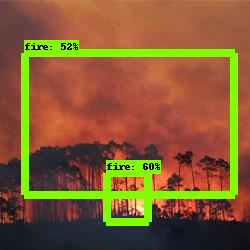

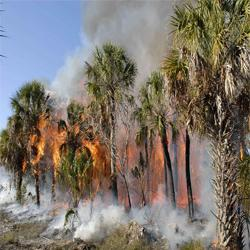

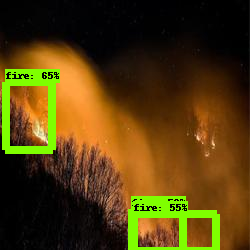

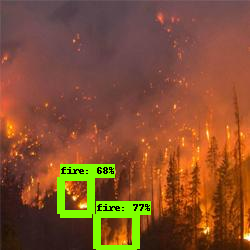

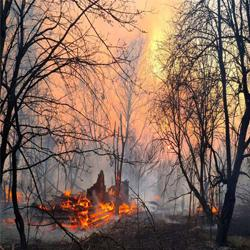

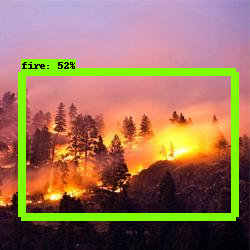

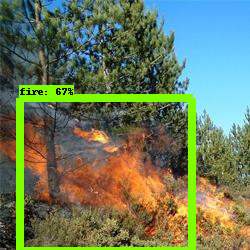

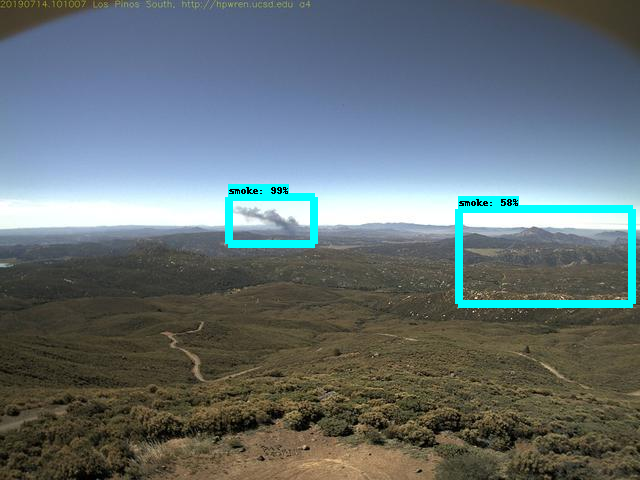

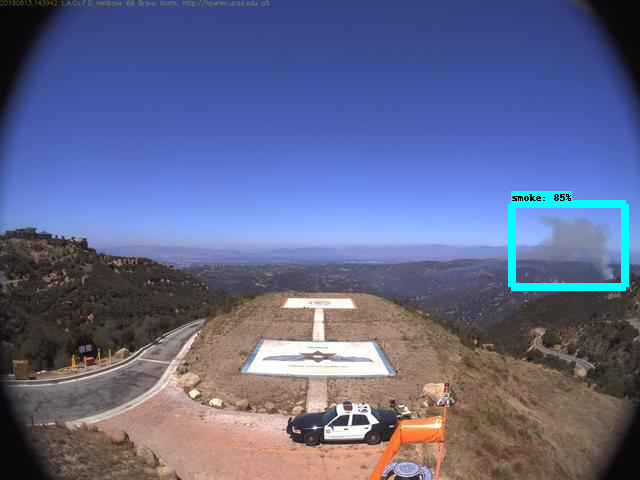

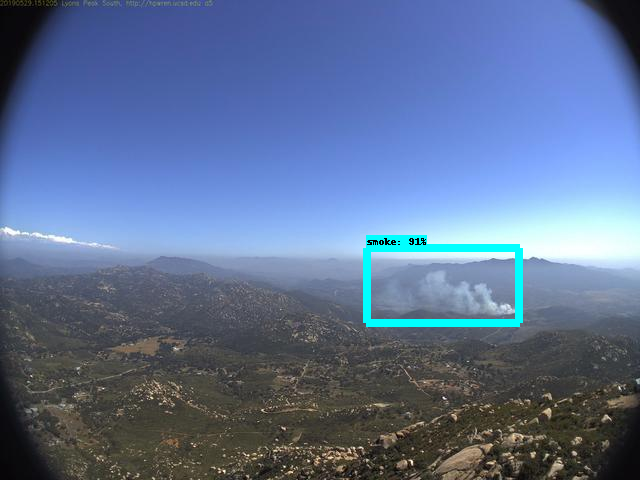

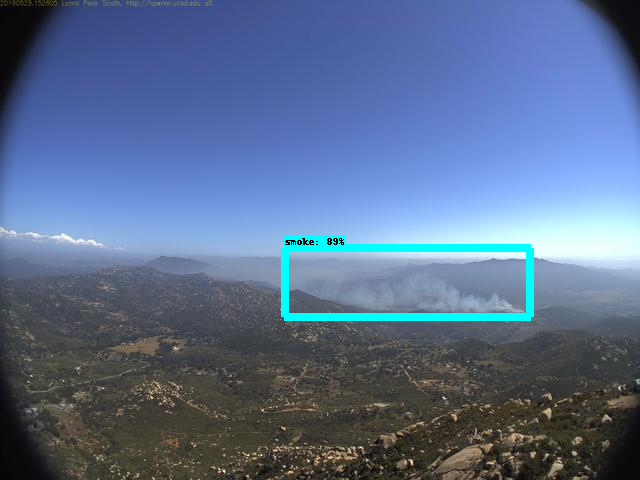

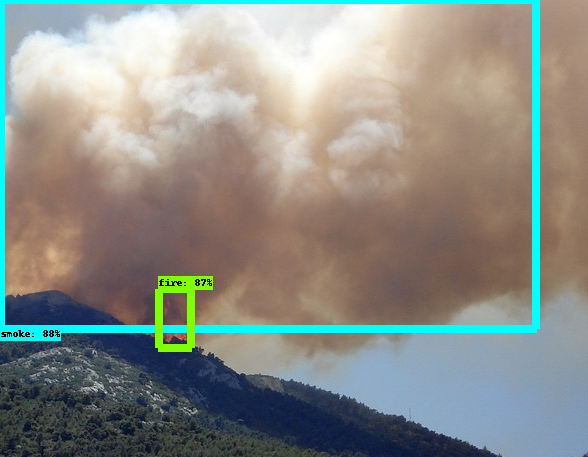

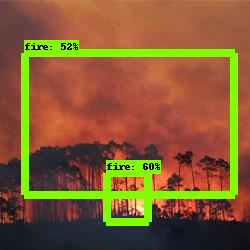

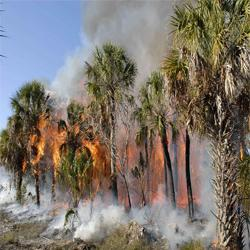

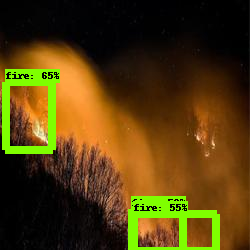

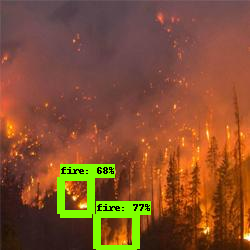

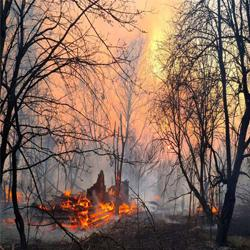

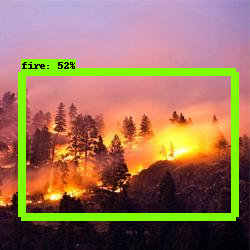

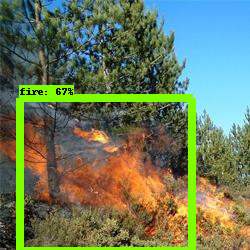

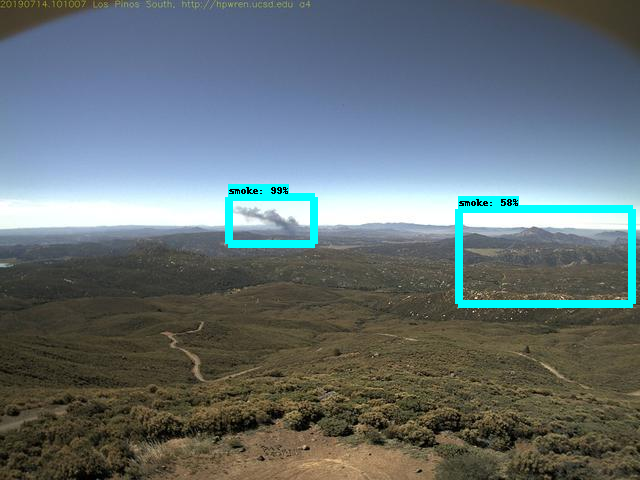

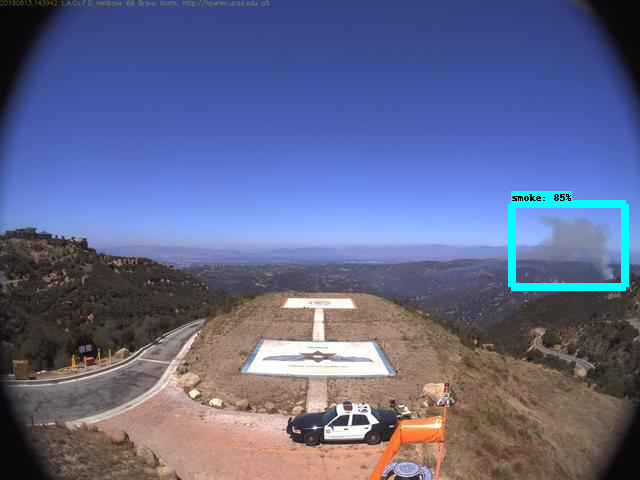

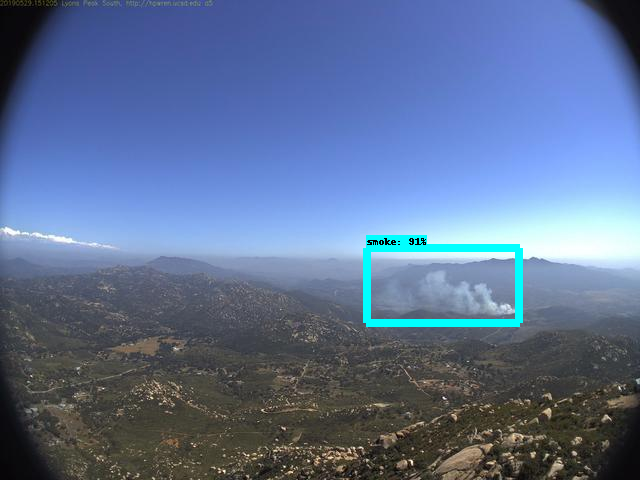

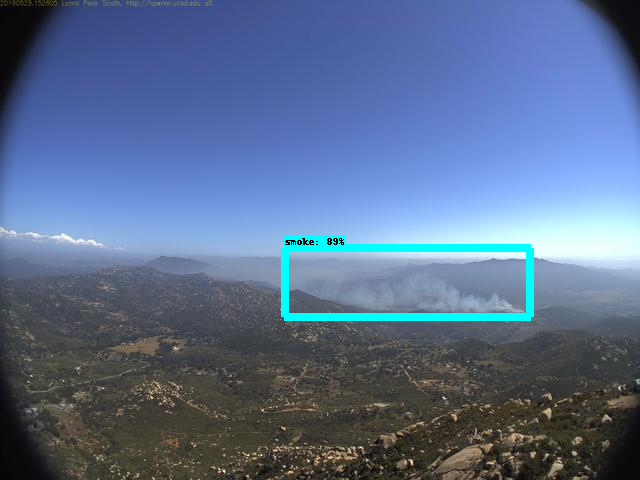

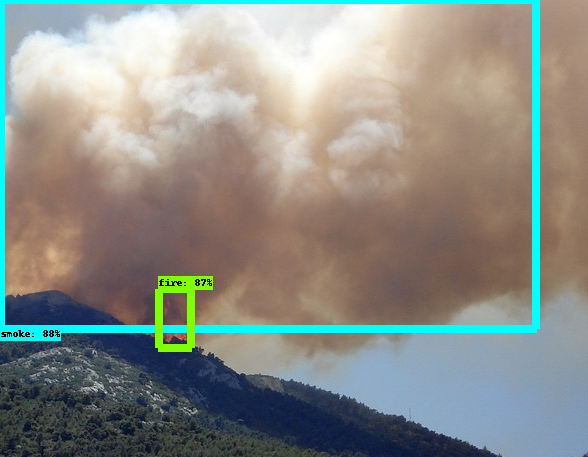

In [14]:
for image_path in test_images:
  image_np = load_image_into_numpy_array(str(image_path))
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)
  display(Image.fromarray(image_np))